In [1]:
import numpy as np                   # advanced math library
import matplotlib.pyplot as plt      # MATLAB like plotting routines
import random                        # for generating random numbers

from keras.datasets import mnist     # MNIST dataset is included in Keras
from keras.models import Sequential  # Model type to be used

from keras.layers.core import Dense, Dropout, Activation # Types of layers to be used in our model
from keras.utils import np_utils                         # NumPy related tools

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Flatten, Reshape
from keras.layers.normalization import BatchNormalization

import keras

In [2]:
# The MNIST data is split between 60,000 28 x 28 pixel training images and 10,000 28 x 28 pixel images
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000, 28, 28, 1) #add an additional dimension to represent the single-channel
X_test = X_test.reshape(10000, 28, 28, 1)

X_train = X_train.astype('float32')         # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                              # normalize each value for each pixel for the entire vector for each input
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 28, 28, 1)
Testing matrix shape (10000, 28, 28, 1)


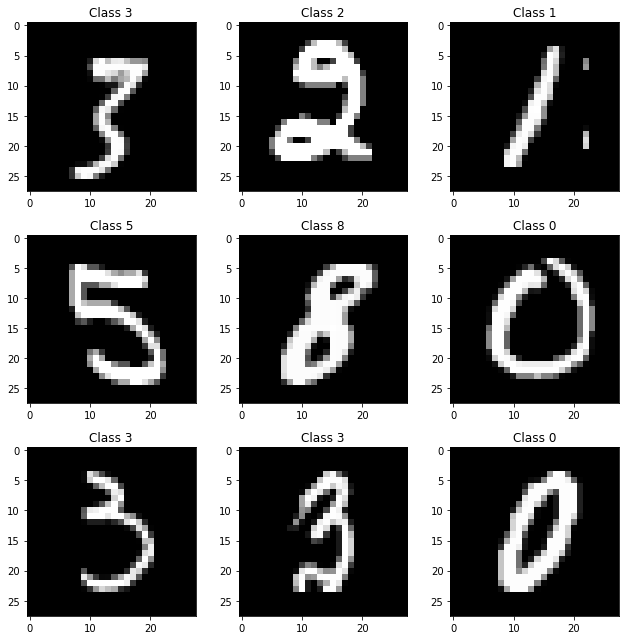

In [3]:
plt.rcParams['figure.figsize'] = (9,9) # Make the figures a bit bigger

for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(X_train))
    plt.imshow(X_train[num], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[num]))
    
plt.tight_layout()

In [4]:
nb_classes = 10 # number of unique digits

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [5]:
# The Sequential model is a linear stack of layers and is very common.

model = Sequential()                                 # Linear stacking of layers

# Convolution Layer 1
model.add(Conv2D(32, (3, 3), input_shape=(28,28,1))) # 32 different 3x3 kernels -- so 32 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
convLayer01 = Activation('relu')                     # activation
model.add(convLayer01)

# Convolution Layer 2
model.add(Conv2D(32, (3, 3)))                        # 32 different 3x3 kernels -- so 32 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
model.add(Activation('relu'))                        # activation
convLayer02 = MaxPooling2D(pool_size=(2,2))          # Pool the max values over a 2x2 kernel
model.add(convLayer02)

# Convolution Layer 3
model.add(Conv2D(64,(3, 3)))                         # 64 different 3x3 kernels -- so 64 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
convLayer03 = Activation('relu')                     # activation
model.add(convLayer03)

# Convolution Layer 4
model.add(Conv2D(64, (3, 3)))                        # 64 different 3x3 kernels -- so 64 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
model.add(Activation('relu'))                        # activation
convLayer04 = MaxPooling2D(pool_size=(2,2))          # Pool the max values over a 2x2 kernel
model.add(convLayer04)
model.add(Flatten())                                 # Flatten final 4x4x64 output matrix into a 1024-length vector

# Fully Connected Layer 5
model.add(Dense(512))                                # 512 FCN nodes
model.add(BatchNormalization())                      # normalization
model.add(Activation('relu'))                        # activation

# Fully Connected Layer 6                       
model.add(Dropout(0.2))                              # 20% dropout of randomly selected nodes
model.add(Dense(10))                                 # final 10 FCN nodes
model.add(Activation('softmax'))                     # softmax activation

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0

In [7]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
# data augmentation prevents overfitting by slightly changing the data randomly
# Keras has a great built-in feature to do automatic augmentation

gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)

test_gen = ImageDataGenerator()

In [9]:
# We can then feed our augmented data in batches
# Besides loss function considerations as before, this method actually results in significant memory savings
# because we are actually LOADING the data into the network in batches before processing each batch

# Before the data was all loaded into memory, but then processed in batches.

train_generator = gen.flow(X_train, Y_train, batch_size=128)
test_generator = test_gen.flow(X_test, Y_test, batch_size=128)

In [10]:
# We can now train our model which is fed data by our batch loader
# Steps per epoch should always be total size of the set divided by the batch size

# SIGNIFICANT MEMORY SAVINGS (important for larger, deeper networks)

history = model.fit(train_generator, steps_per_epoch=60000//128, epochs=2, verbose=1, 
                    validation_data=test_generator, validation_steps=10000//128)

Epoch 1/2
468/468 [==============================] - 117s 250ms/step - loss: 0.1302 - accuracy: 0.9597 - val_loss: 0.0570 - val_accuracy: 0.9832
Epoch 2/2
468/468 [==============================] - 136s 291ms/step - loss: 0.0495 - accuracy: 0.9843 - val_loss: 0.0372 - val_accuracy: 0.9874


In [12]:
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 4s 12ms/step - loss: 0.0371 - accuracy: 0.9874
Test score: 0.037138957530260086
Test accuracy: 0.9873999953269958


In [14]:
model.save("mlmodels/kerasdnn1/")
#keras.models.load_model("mlmodels/kerasdnn1")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: mlmodels/kerasdnn1/assets
